<a href="https://colab.research.google.com/github/jaeohshin/keras/blob/main/tutorial_5_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we use Convnet to distinguish between dogs and cats from kaggle data.


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaeohshin","key":"b06496892a173235f5af3b31663da13d"}'}

In [2]:
!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaeohshin","key":"b06496892a173235f5af3b31663da13d"}'}

In [15]:
! rm -r ~/.kaggle

In [16]:
!mkdir ~/.kaggle

In [17]:
mv ./kaggle.json ~/.kaggle/

In [20]:
!chmod 600 ~/.kaggle/kaggle.json

In [40]:
!pwd

/content


In [41]:
!ls

 dogs-vs-cats.zip   sample_data		   test1       train
'kaggle (1).json'   sampleSubmission.csv   test1.zip   train.zip


In [43]:
!rm -rf *

In [44]:
!ls

In [45]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:04<00:00, 236MB/s]
100% 812M/812M [00:04<00:00, 187MB/s]


In [46]:
!ls

dogs-vs-cats.zip


In [47]:
!unzip -qq dogs-vs-cats.zip

In [48]:
!ls

dogs-vs-cats.zip  sampleSubmission.csv	test1.zip  train.zip


In [49]:
!unzip -qq train.zip

In [50]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Building a model

In [57]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [58]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [59]:
model.compile(loss = "binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [60]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [61]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("label batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
label batch shape: (32,)


In [62]:
callbacks = [
    keras.callbacks.ModelCheckpoint (
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]



In [63]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 96ms/step - loss: 0.6957 - accuracy: 0.5085 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6930 - accuracy: 0.5305 - val_loss: 0.6856 - val_accuracy: 0.5880
Epoch 3/30
63/63 [==============================] - 5s 80ms/step - loss: 0.6861 - accuracy: 0.5925 - val_loss: 0.8685 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6591 - accuracy: 0.6185 - val_loss: 0.6703 - val_accuracy: 0.5720
Epoch 5/30
63/63 [==============================] - 5s 78ms/step - loss: 0.6199 - accuracy: 0.6710 - val_loss: 0.6254 - val_accuracy: 0.6280
Epoch 6/30
63/63 [==============================] - 4s 61ms/step - loss: 0.5780 - accuracy: 0.6800 - val_loss: 0.5814 - val_accuracy: 0.6800
Epoch 7/30
63/63 [==============================] - 4s 61ms/step - loss: 0.5577 - accuracy: 0.7080 - val_loss: 0.5883 - val_accuracy: 0.7000
Epoch 8/30
6

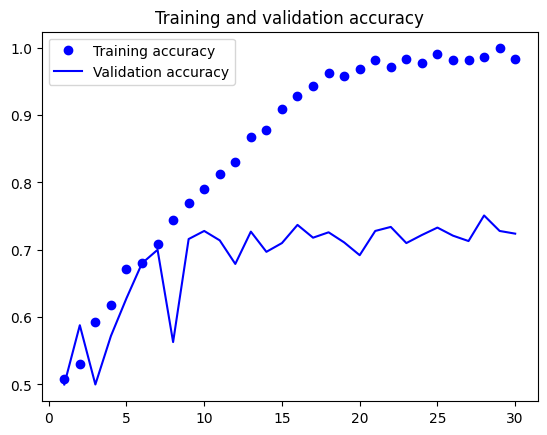

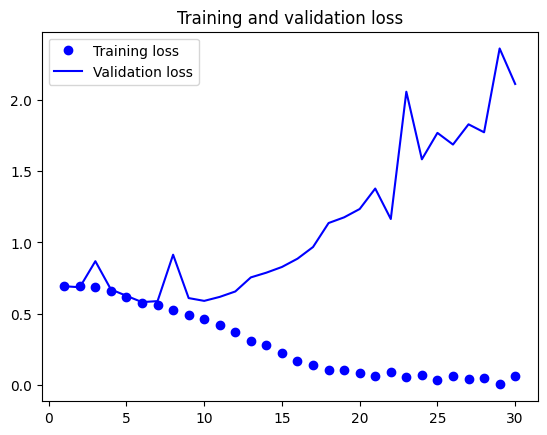

In [64]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [66]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc: .3f}")

63/63 [==============================] - 2s 32ms/step - loss: 0.5893 - accuracy: 0.6855
Test accuracy:  0.686


The accuracy is about 68%. We need to use several techniques to improve it below.